# Selecting a Representative Year for Life Expectancy Analysis

This notebook explores strategies for selecting a representative year from the LE dataset. We'll examine:

1. **Data completeness** across years
2. **Number of anomalies** across year
4. **Recommended year selection** based on a fused score

The goal is to identify a single year that:
- Maximizes data completeness
- Represents modern conditions (recent years preferred)
- Minimizes missing values across all features

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ama_tlbx.data import LECol, LifeExpectancyDataset

# Configure plotting
sns.set_style("whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.titlesize"] = 12
plt.rcParams["figure.labelsize"] = 11
plt.rcParams["figure.titleweight"] = "bold"


In [2]:
le_ds = LifeExpectancyDataset.from_csv(
    aggregate_by_country=False,
    drop_missing_target=False,
)

df = le_ds.df

print(f"Total observations: {len(df):,}")
print(f"Countries: {df[LECol.COUNTRY].nunique()}")
print(f"Years: {df[LECol.YEAR].nunique()}")
print(
    f"Year range: {df[LECol.YEAR].dt.year.min():.0f} - {df[LECol.YEAR].dt.year.max():.0f}"
)


Total observations: 2,938
Countries: 193
Years: 16
Year range: 2000 - 2015


## Data Completeness by Year

In [3]:
# Calculate completeness metrics by year
numeric_cols = le_ds.numeric_cols

year_stats = (
    df.groupby(LECol.YEAR)
    .agg(
        n_countries=(LECol.COUNTRY, "count"),
        n_countries_with_target=(LECol.TARGET, lambda x: x.notna().sum()),
        pct_missing_target=(LECol.TARGET, lambda x: x.isna().mean() * 100),
        # missing data across all numeric columns
        pct_missing_all=(
            numeric_cols[0],
            lambda x: df.loc[x.index, numeric_cols].isna().mean().mean() * 100,
        ),
    )
    .reset_index()
    .assign(
        completeness_score=lambda d: d["n_countries_with_target"]
        * (100 - d["pct_missing_all"])
        / d["n_countries"]
    )
    .sort_values(by="completeness_score", ascending=False)
)

year_stats


,year,n_countries,n_countries_with_target,pct_missing_target,pct_missing_all,completeness_score
14,2014-01-01,183,183,0.000000,3.106126,96.893874
11,2011-01-01,183,183,0.000000,3.163647,96.836353
12,2012-01-01,183,183,0.000000,3.221168,96.778832
10,2010-01-01,183,183,0.000000,3.278689,96.721311
9,2009-01-01,183,183,0.000000,3.336209,96.663791
8,2008-01-01,183,183,0.000000,3.422491,96.577509
7,2007-01-01,183,183,0.000000,3.537532,96.462468
6,2006-01-01,183,183,0.000000,3.767616,96.232384
5,2005-01-01,183,183,0.000000,3.968939,96.031061
4,2004-01-01,183,183,0.000000,4.199022,95.800978


## 3. Visualize Data Completeness Over Time

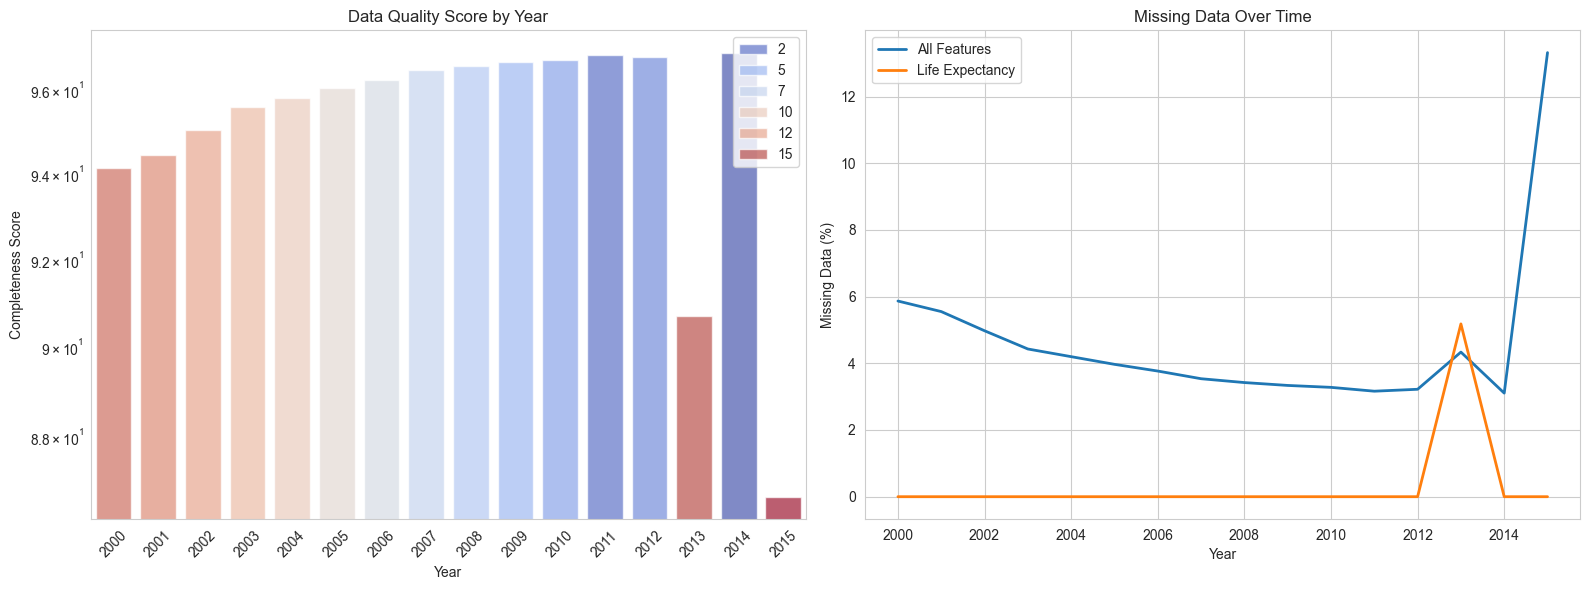

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sort by year for time series plots
year_stats_time = year_stats.sort_values(LECol.YEAR).assign(
    year=lambda d: d[LECol.YEAR].dt.year,
    # rank by completeness score
    completeness_rank=lambda d: d["completeness_score"]
    .rank(ascending=False)
    .astype(int),
)

# 1. Completeness score
sns.barplot(
    data=year_stats_time,
    x="year",
    y="completeness_score",
    hue="completeness_rank",
    alpha=0.7,
    ax=ax1,
    palette="coolwarm",
)
ax1.legend()
ax1.set_xlabel("Year")
ax1.set_ylabel("Completeness Score")
ax1.set_title("Data Quality Score by Year")
ax1.tick_params(axis="x", rotation=45)
ax1.set_yscale("log")

# 2. Missing data percentage
sns.lineplot(
    data=year_stats_time.melt(
        id_vars="year",
        value_vars=["pct_missing_all", "pct_missing_target"],
        var_name="Category",
        value_name="Missing %",
    ).replace(
        {"pct_missing_all": "All Features", "pct_missing_target": "Life Expectancy"}
    ),
    x="year",
    y="Missing %",
    hue="Category",
    markers=True,
    dashes=False,
    linewidth=2,
    ax=ax2,
)
ax2.set_xlabel("Year")
ax2.set_ylabel("Missing Data (%)")
ax2.set_title("Missing Data Over Time")
ax2.legend(title=None)

plt.tight_layout()
plt.show()


### Observations

- There is a clear trend of increasing completeness scores in more recent years.
- By far the lowest completeness score is seen for 2015, this is probably due to missing integration of the collected data for that year.
    $\implies$ 2015 should be excluded as representative year.
- 2014 has the highest completeness score, making it a strong candidate for selection.
- We will further investigate 2007 to 2014 (excluding 2013) for final year selection.

Index([2014, 2012, 2011, 2010, 2009, 2008, 2007], dtype='int32', name='year')


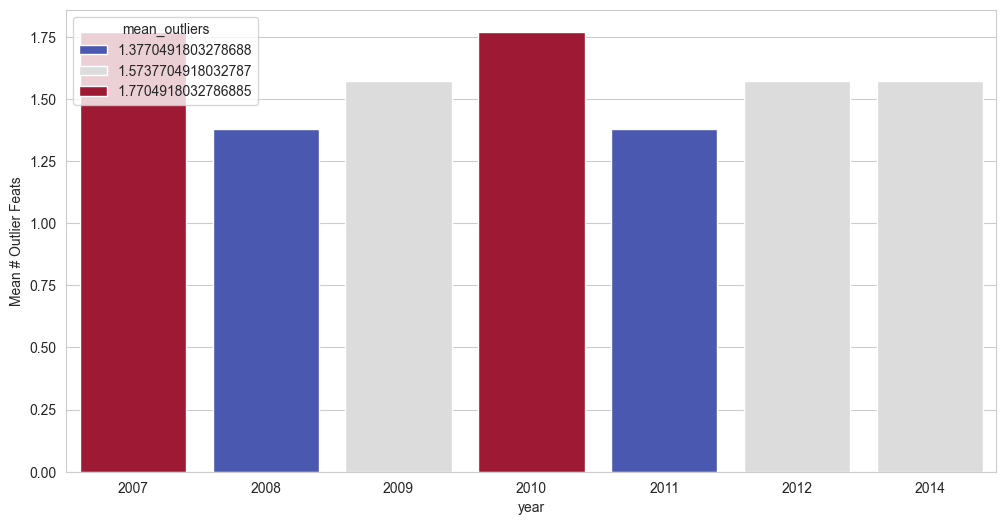

In [ ]:
candidate_years = list(range(2007, 2015))
candidate_years.remove(2013)

ds = LifeExpectancyDataset(
    df=df[df[LECol.YEAR].dt.year.isin(candidate_years)].set_index(LECol.YEAR)
)
print(ds.df.index.year.unique())

iso_forest_results = (
    ds.make_isolation_forest_outlier_detector(n_estimators=100).fit().result()
)

df_mean_outliers = (
    iso_forest_results.n_outliers_per_row.reset_index()
    .groupby(LECol.YEAR)
    .mean()
    .reset_index()
    .assign(year=lambda d: d[LECol.YEAR].dt.year)
    .rename(columns={0: "mean_outliers"})
    .sort_values("mean_outliers")
)

sns.barplot(
    df_mean_outliers,
    x=LECol.YEAR,
    y="mean_outliers",
    hue="mean_outliers",
    palette="coolwarm",
)
plt.ylabel("Mean # Outlier Feats")
plt.show()


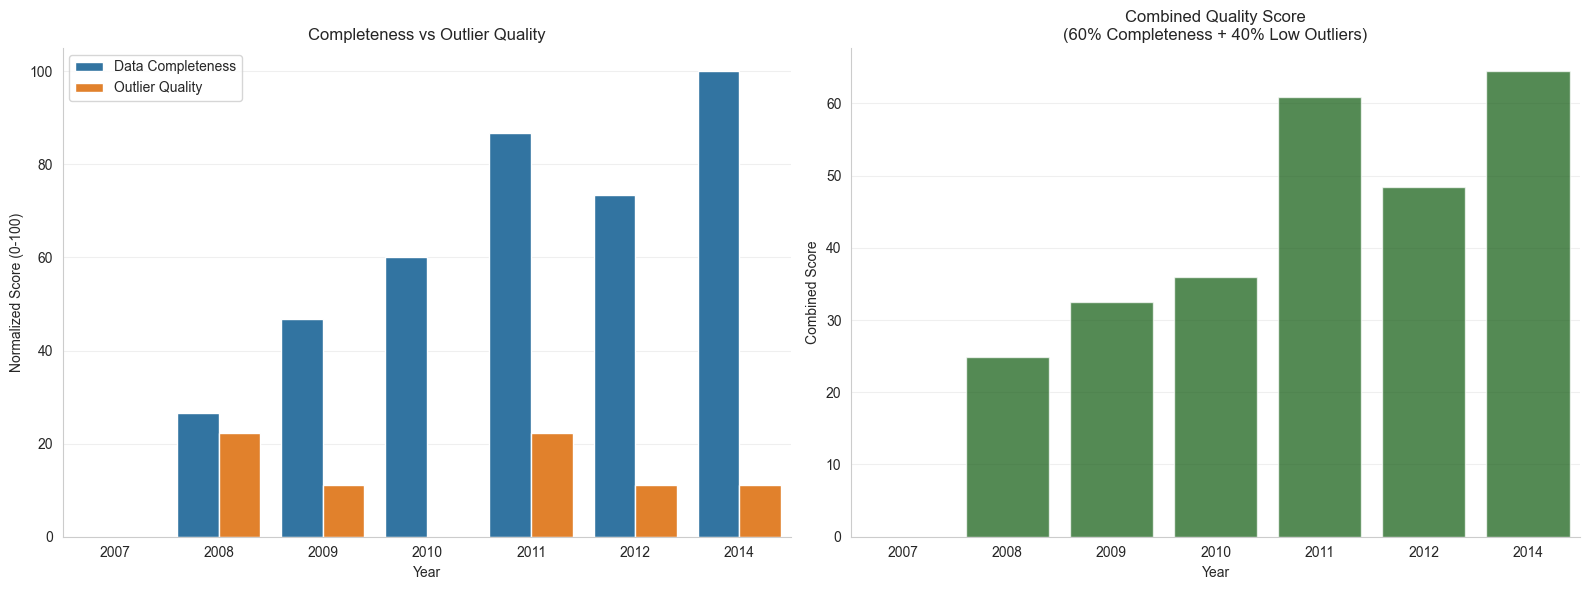


FINAL YEAR RECOMMENDATION
  Best year: 2014
   Combined score: 64.4/100
   Completeness: 96.9
   Mean outliers: 1.57


In [18]:
# Build comparison dataframe with method chaining
comparison_df = (
    year_stats[year_stats[LECol.YEAR].dt.year.isin(candidate_years)]
    .assign(year=lambda d: d[LECol.YEAR].dt.year)[["year", "completeness_score"]]
    .merge(
        iso_forest_results.n_outliers_per_row.reset_index()
        .assign(year=lambda d: d[LECol.YEAR].dt.year)
        .groupby("year", as_index=False)
        .agg(mean_outliers=(0, "mean")),
        on="year",
    )
    .assign(
        completeness_norm=lambda d: (
            d["completeness_score"] - d["completeness_score"].min()
        )
        / (d["completeness_score"].max() - d["completeness_score"].min())
        * 100,
        outlier_quality_norm=lambda d: (
            1 - d["mean_outliers"] / d["mean_outliers"].max()
        )
        * 100,
        combined_score=lambda d: d["completeness_norm"] * 0.6
        + d["outlier_quality_norm"] * 0.4,
    )
)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Dual metrics
sns.barplot(
    data=comparison_df.melt(
        id_vars="year",
        value_vars=["completeness_norm", "outlier_quality_norm"],
        var_name="Metric",
        value_name="Score",
    ).replace(
        {
            "completeness_norm": "Data Completeness",
            "outlier_quality_norm": "Outlier Quality",
        }
    ),
    x="year",
    y="Score",
    hue="Metric",
    ax=ax1,
)
ax1.set(
    xlabel="Year",
    ylabel="Normalized Score (0-100)",
    title="Completeness vs Outlier Quality",
)
ax1.legend(title=None)
ax1.grid(True, alpha=0.3, axis="y")

# 2. Combined score
sns.barplot(
    data=comparison_df,
    x="year",
    y="combined_score",
    color="darkgreen",
    alpha=0.7,
    ax=ax2,
)

best_idx = comparison_df["combined_score"].idxmax()
best_year = comparison_df.loc[best_idx, "year"]

ax2.set(
    xlabel="Year",
    ylabel="Combined Score",
    title="Combined Quality Score\n(60% Completeness + 40% Low Outliers)",
)
ax2.grid(True, alpha=0.3, axis="y")
sns.despine(fig=fig)
plt.tight_layout()
plt.show()

# Print recommendation
print(f"\n{'=' * 70}\nFINAL YEAR RECOMMENDATION\n{'=' * 70}")
print(f"  Best year: {int(best_year)}")
print(f"   Combined score: {comparison_df.loc[best_idx, 'combined_score']:.1f}/100")
print(f"   Completeness: {comparison_df.loc[best_idx, 'completeness_score']:.1f}")
print(f"   Mean outliers: {comparison_df.loc[best_idx, 'mean_outliers']:.2f}")
print("=" * 70)
